# Iterative Phase Estimation

The goal of this exercise is to understand how the Iterative Phase Estimation (IPE) algorithm uses dynamic circuits, and, [why would we use the IPE algorithm instead of the QPE (Quantum Phase Estimation) algorithm](https://arxiv.org/abs/2102.01682). We demonstrate how to performed this algorithm with Qiskit using circuits containing `reset`, in order to apply gates conditioned by the values resulting from previous measurements and stored in a classical register.

If you want learn more about iterative phase estimation visit the references below.

**References**

- [Qiskit Textbook, Section 2 of Lab 4: Iterative Phase Estimation (IPE) Algorithm](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm)
- [Qiskit Textbook, Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html)
- [Exploiting dynamic quantum circuits in a quantum algorithm with superconducting qubits](https://arxiv.org/abs/2102.01682)
- [Arbitrary accuracy iterative phase estimation algorithm as a two qubit benchmark](https://arxiv.org/abs/quant-ph/0610214)

### Preamble

In [1]:
import os
from typing import Any, List, Dict, Union

import numpy as np
import matplotlib.pyplot as plt

from qiskit import (
    Aer,
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    transpile,
    execute,
)
from qiskit.tools.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider

import warnings

warnings.filterwarnings("ignore")

pi = np.pi

In [2]:
# define backend to request
# Note: This can be any hub/group/project that has access to the required device and Qiskit Runtime.
hub = "<hub>"
group = "<group>"
project = "<project>"
backend_name = "<your backend>"
hgp = f"{hub}/{group}/{project}"

hub = "ibm-q-internal"
group = "dev-sys-software"
project = "internal-test"
backend_name = "alt_auckland"
hgp = f"{hub}/{group}/{project}"

In [3]:
# load backend
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
backend_sim = Aer.get_backend("aer_simulator")
# backend = least_busy(provider.backends(dynamic_circuits=True))
print(f"Using backend {backend.name}")

## Iterative phase estimation

The motivation for using the IPE algorithm is that the Quantum Phase Estimation algorithm works fine for short depth circuits, but when the circuit starts to grow, it doesn't work properly due to gate noise and decoherence times.

The detailed explanation of how the algorithm works can be found in [Iterative Phase Estimation (IPE) Algorithm](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm). To understand QPE in depth, you can see also [Ch.3.6 Quantum Phase Estimation](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html).

### IPE example with a 1-qubit gate for $U$

We want to apply the IPE algorithm to estimate the phase for a 1-qubit operator $U$.  For example, here we use the $S$-gate.

Let's apply the IPE algorithm to estimate the phase for $S$-gate.
Its matrix is

$$ S =
\begin{bmatrix}
1 & 0\\\\
0 & e^\frac{i\pi}{2}\\\\
\end{bmatrix}$$

That is, the $S$-gate adds a phase $\pi/2$ to the state $|1\rangle$, leaving unchanged the phase of the state $|0\rangle$

$$ S|1\rangle = e^\frac{i\pi}{2}|1\rangle $$

In the following, we will use the notation and terms used in [Section 2 of lab 4](https://qiskit.org/textbook/ch-labs/Lab04_IterativePhaseEstimation.html#2-iterative-phase-estimation-ipe-algorithm) of the Qiskit textbook.

To estimate the phase $\phi=\frac{\pi}{2}$ for the eigenstate $|1\rangle$, we should find $\varphi=\frac{1}{4}$ (where $\phi = 2 \pi \varphi$). Therefore to estimate the phase we need exactly two phase bits, i.e. $m=2$, since $1/2^2=1/4$. So $\varphi=0.\varphi_1\varphi_2$.

Remember from the theory that for the IPE algorithm, $m$ is also the number of iterations, so we need only $2$ iterations or steps.

First, we initialize the circuit. IPE works with only 1 auxiliary qubit, instead of $m$ counting qubits of the QPE algorithm. Therefore, we need 2 qubits, 1 auxiliary qubit and 1 for the eigen state of $U$-gate, and a classical register of 2 bits, for the phase bits $\varphi_1$, $\varphi_2$.

## IPE - First step

Now we build the quantum circuit for the first step, that is, the first iteration of the algorithm, to estimate the least significant phase bit $\varphi_m$, which in this case id $\varphi_2$. For the first step we have four sub-steps:

- qubit initialization
- initialization
- application of the Controlled-$U$ gates
- measure of the auxiliary qubit in x-basis


In [4]:
qubits = [0, 1]
shots = 1000

nq = 2
m = 2

In [5]:
qr = QuantumRegister(2, "q")
c0 = ClassicalRegister(1, "c0")
c1 = ClassicalRegister(1, "c1")
qc_S = QuantumCircuit(qr, c0, c1)

### Eigenstate Initialization

The initialization consists of application the Hadamard gate to the auxiliary qubit and the preparation of the eigenstate $|1\rangle$.

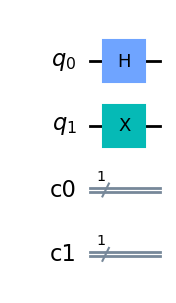

In [6]:
def initialize_eigenstate(qc):
    """Initialize the eigenstate and prepare our ancilla qubit"""
    qc.h(0)
    qc.x(1)


initialize_eigenstate(qc_S)
qc_S.draw("mpl")

### Application of the Controlled-$U$ gates

We now have to apply $2^t$ times the Controlled-$U$ operators (see also in the docs [Two qubit gates](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Two-qubit-gates)), that, in this example, is the Controlled-$S$ gate ($CS$ for short).

To implement $CS$ in the circuit, since $S$ is a phase gate, we can use the controlled phase gate $\text{CP}(\theta)$, with $\theta=\pi/2$.

In [7]:
theta = 1 * np.pi / 2

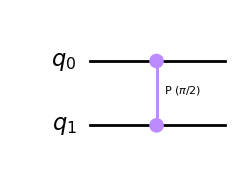

In [8]:
cu_circ = QuantumCircuit(2)
cu_circ.cp(theta, 0, 1)
cu_circ.draw("mpl")

Let's apply $2^t$ times $\text{CP}(\pi/2)$. Since for the first step $t=m-1$, and $m=2$, we have $2^t=2$.

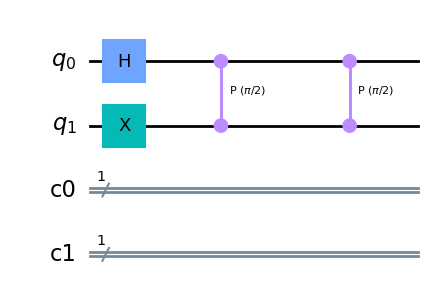

In [9]:
for _ in range(2 ** (m - 1)):
    qc_S.cp(theta, 0, 1)
qc_S.draw("mpl")

### Measure in x-basis

Finally, we perform the measurenment of the auxiliary qubit in x-basis.

In this way we obtain the phase bit $\varphi_2$ and store it in the classical bit $c_0$.

**Note**: The eigenvectors of the Hadamard gate are the basis vectors of the x-basis.

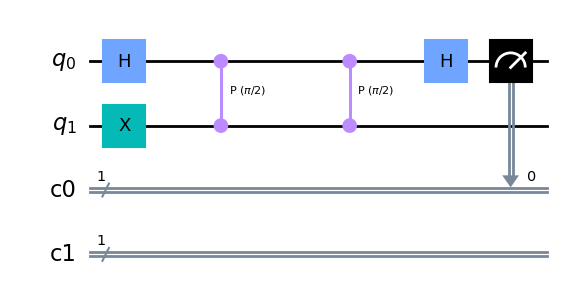

In [10]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)


x_measurement(qc_S, qr[0], c0)
qc_S.draw("mpl")

## Subsequent steps - Second step

Now we build the quantum circuit for the other remaining steps, in this example, only the second one.
In these steps we have four sub-steps: the three sub-steps as in the first step and, in the middle, the additional step of the phase correction
- initialization with reset
- phase correction
- application of the Control-$U$ gates
- measure of the auxiliary qubit in x-basis


### Reset the auxiliary qubit

As we want to perform an iterative algorithm in the same circuit, we need to reset the auxiliary qubit $q0$ after the measument gate and initialize it again as before to recycle the qubit.

We use the builtin `qc.reset` operation to perform a reset of qubit 0 followed by the hadamard operation.

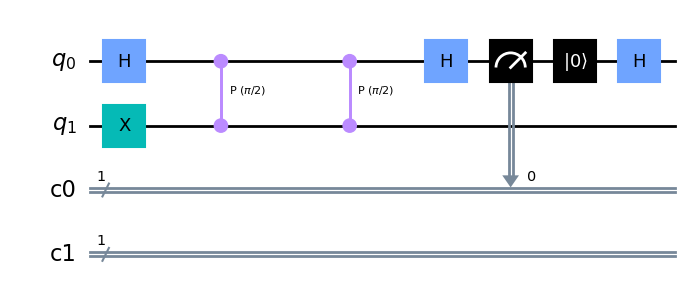

In [11]:
def reset_auxiliary(qc):
    qc.reset(0)
    qc.h(0)


reset_auxiliary(qc_S)
qc_S.draw("mpl")

### Phase correction (for step 2)
As seen in the theory, in order to extract the phase bit $\varphi_{1}$, we perform a phase correction of $-\pi\varphi_2/2$.
Of course, we need to apply the phase correction in the circuit only if the phase bit $\varphi_2=1$, i.e. we have to apply the phase correction of $-\pi/2$ only if the classical bit $c_0$ is 1.

So, after the reset we apply the phase gate $P(\theta)$ with phase $\theta=-\pi/2$ conditioned by the classical bit $c_0$ ($=\varphi_2$).

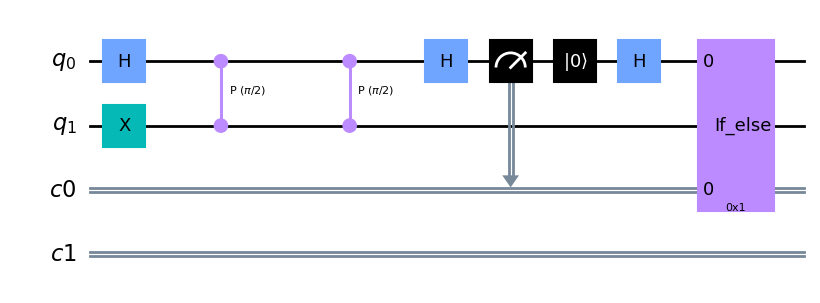

In [12]:
with qc_S.if_test((c0, 1)):
    qc_S.p(-np.pi / 2, 0)
qc_S.draw("mpl")

### Apply the controlled-$U$ gates and x-measurement (for step 2)

We apply the $CU$ operations as we did in the first step. For the second step we have $t=m-2$, hence $2^t=1$. So we apply $\text{CP}(\pi/2)$ once. And then we perform the x-measurment of the qubit $q_0$, storing the result, the phase bit $\varphi_1$, in the bit $c_1$ of classical register.

In [13]:
## 2^t c-U operations (with t=m-2)
for _ in range(2 ** (m - 2)):
    qc_S.cp(theta, 0, 1)

x_measurement(qc_S, qr[0], c1)

We now have our final circuit!

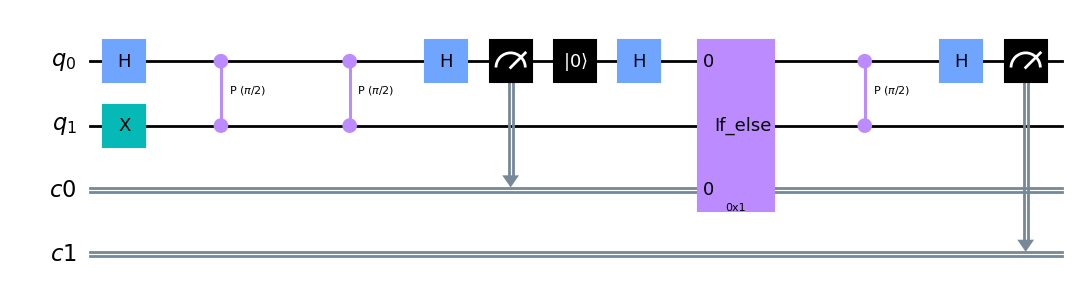

In [14]:
qc_S.draw("mpl")

Let's execute the circuit with the `qasm_simulator`, the simulator without noise that run locally.

In [15]:
count = execute(qc_S, backend_sim).result().get_counts()
count

{'0 1': 1024}

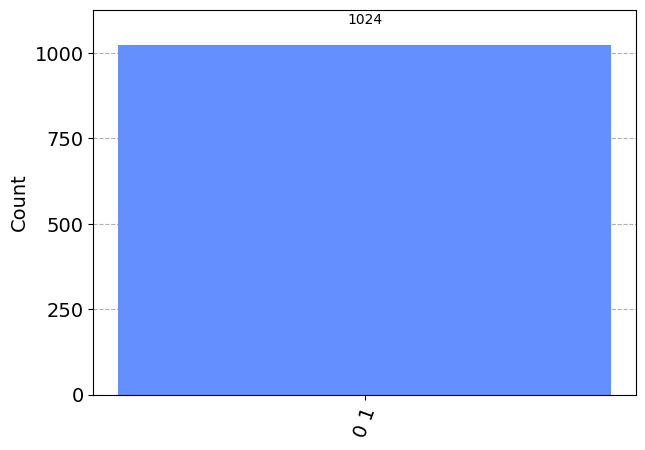

In [16]:
count0 = execute(qc_S, backend_sim).result().get_counts()
plot_histogram(count0)

In [17]:
count0

{'0 1': 1024}

In the picture we have the same histograms but on the left we have on the x-axis the string with phase bits $\varphi_1$, $\varphi_2$ and on the right the actual phase $\varphi$ in decimal representation.

As we expected we have found $\varphi=\frac{1}{4}=0.25$ with a $100\%$ probability.

## Run on real hardware

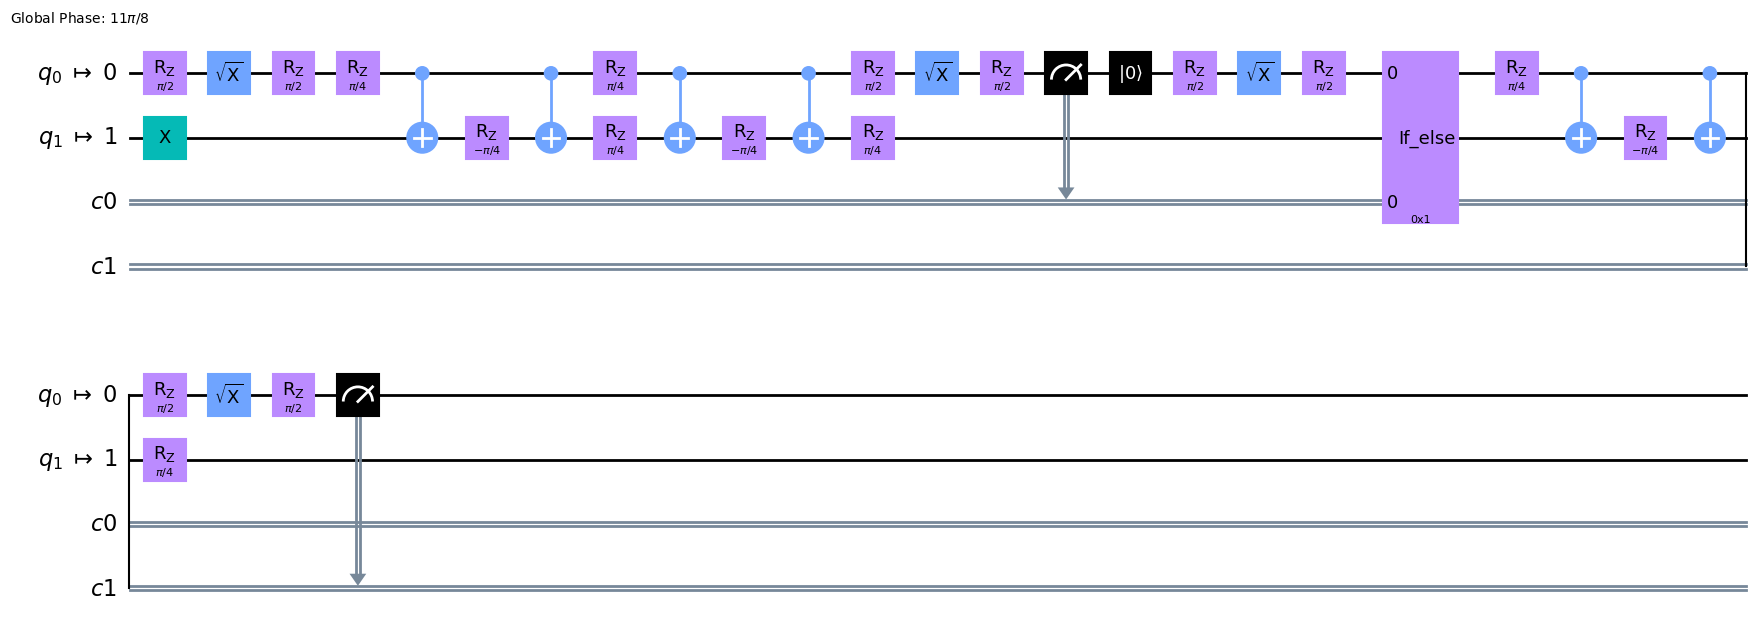

In [18]:
qc_S_backend = transpile(qc_S, backend, initial_layout=qubits, optimization_level=1)
qc_S_backend.draw(output="mpl", idle_wires=False)

In [19]:
real_ipe_job = backend.run(qc_S_backend, dynamic=True, shots=shots)
print(f"IPE job id: {real_ipe_job.job_id()}")

IPE job id: cggspko51vfr6ftg6fq0


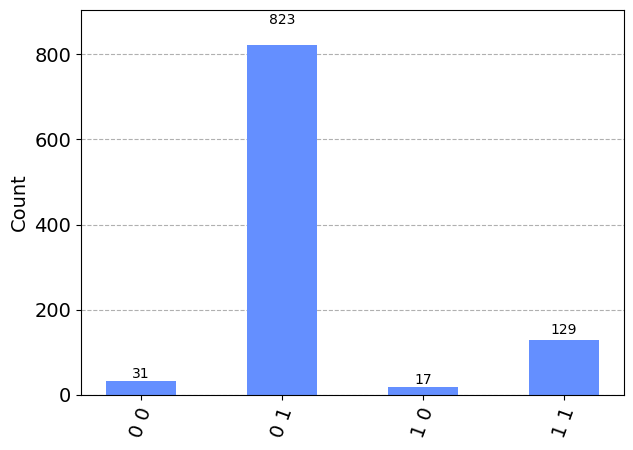

In [20]:
real_counts0 = real_ipe_job.result().get_counts()
plot_histogram(real_counts0)

As expected, we estimate the correct result of `01` the majority of the time.

Now that we have estimated the phase of the $S$ gate, lets try finding the phase of another gate. Lets this by using that fact that we implemented IPE for `S` using the $P(\theta)$ gate. Choose a new instance of the $P$ gate that can be estimated with two bits of precision and rerun.

After you have mastered IPE for two bits of precision, try adding a third bit. Modify the code of this exercise to add another round of IPE.


In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table